In [1]:
using Pkg
Pkg.activate(".")

  Activating environment at `~/GitHub/ml-for-phasefield/models/Julia/Project.toml`


We will solve the following Allen-Cahn problem in 2D:

$$
\begin{align}
\frac{1}{M}{\partial_t\phi}&=\underbrace{\partial_{x}^{2}\phi+\partial_{y}^{2}\phi}_{\mathrm{Laplace-Operator}}-\frac{2}{\xi^2}{\partial_\phi g(\phi)}-\frac{\mu_{0}}{3\Gamma\xi}{\partial_\phi h(\phi)}. \\
\phi \in \R^2 \\
\phi(x,0) = \phi_0 \\
\frac{\partial \phi}{\partial x} = 0 \quad\forall x \in \partial \Omega
\end{align}
$$

Using the method of lines (MOL) on a Finite Difference grid, i.e. we discretize the problem in all dimensions but one.

With this approach, we obtain a set of ordinary differential equations that we can subsequently solve using any suitable high-order method.

In [2]:
using DifferentialEquations, Plots
gr()

Plots.GRBackend()

We will denote the partial derivatives of the source terms with `dg` and `dh` respectively

In [3]:
function dg(ϕ)
    return 2.0 * ϕ * (1.0 - ϕ) * (1.0 - 2.0 * ϕ)
end

dg (generic function with 1 method)

In [4]:
function dh(ϕ)
    return 6.0 * ϕ * (1.0 - ϕ)
end

dh (generic function with 1 method)

In [5]:
function integral(ϕ, Δx)
    return sum(ϕ) * Δx^2
end

integral (generic function with 1 method)

We create a function to impose a Neumann boundary condition on our field:
$$
\frac{\partial \phi}{\partial x} = 0 \quad \forall x \in \partial \Omega
$$

To do this, we simply need to set the derivative field at the domain edge equal to its inward neighbor so that there is no net flux present.

Here, we make use of the broadcasting capabilities of `Julia` by using the dot operator `.`. This tells the compiler to perform the operation element-wise although we pass arrays as arguments. This can be very convenient and expose a very easy way of parallelism without any custom, fancy loops.

In [6]:
function neumann!(ϕ)
    # left
    ϕ[1,:] .= ϕ[2,:]
    # Right
    ϕ[end,:] .= ϕ[end-1,:]
    # Top
    ϕ[:,end] .= ϕ[:,end-1]
    # Bottom
    ϕ[:,1] .= ϕ[:,2]
    return nothing
end

neumann! (generic function with 1 method)

We define the laplacian $\Delta$ using a 5-point central difference stencil. Note that we omit the boundary points when visiting each point of the derivative field $d\phi$ as we would otherwise run into bounds errors.

While we're at it writing loops, we call our source terms `dg` and `dh` simultaneously as the compiler would otherwise have to figure out the fusion of loops by itself.

We give the name of our function a bang `!` as this is Julia convention for functions that mutate their inputs. Those types of functions are quite common in high-performance code since they try to avoid allocations along the way.

With the macro `@inbounds`, we tell the compiler to omit bounds checks when executing the loop. We can get away with this here since we explicitly reference the size of the target arrays in the index bounds, so we are in bounds by definition. If you use this macro carelessly, the program might crash when a real out-of-bounds error occurs, so this is only advised to do if you're sure about what you're doing.

Finally, we can use `@views` to avoid extra allocations as this macro instructs the LLVM compiler to use pointers to the original array instead of making a temporary copy of it. This is a often used way of saving allocations.

In [7]:
function step!(dϕ,ϕ,p)
    @inbounds for i ∈ 2:size(ϕ,1)-1, k ∈ 2:size(ϕ,2)-1
            @views dϕ[i,k] = p[3] * ((ϕ[i+1,k] + ϕ[i-1,k] + ϕ[i,k+1] + ϕ[i,k-1] - 4*ϕ[i,k]) / p[5]^2 - 2.0/p[2]^2 * dg(ϕ[i,k]) + p[4]/(3.0*p[1]*p[2]) * dh(ϕ[i,k]))
        end
    return dϕ
end

step! (generic function with 1 method)

Let's see how our (hopefully non-allocating) semi-discretization fares performance-wise. To benchmark the implementation, we can use the very handy `BenchmarkTools.jl` package, where we get statistically meaningful results. Benchmarking is as simple as annotating the function call with the `@benchmark` macro and interpolating the arguments into the expression by appending a `$`:

In [8]:
using BenchmarkTools
ϕ = zeros(3,100)
dϕ = copy(ϕ);
p = ones(5);
@benchmark step!($dϕ,$ϕ,$p)

BenchmarkTools.Trial: 10000 samples with 207 evaluations.
 Range (min … max):  366.667 ns …   2.795 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     397.585 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   434.753 ns ± 119.264 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁▂▅▅▃▁▁▂▂▃▂▂▁▁   ▁▁▁ ▂▁▂ ▁▁▂▁▂▁                              ▁
  ██████████████████████████████████▇▇▅▇▅▆▇▇▆▆▆▇▆▆▆▅▄▅▅▄▅▅▅▅▄▃▄ █
  367 ns        Histogram: log(frequency) by time        842 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

We don't see any allocations at all which is what we want ideally. Also, we can see that in neither case the Garbage Collector (GC) has to do any work. This can be considered an optimal case.

# Stationary phase front evolution problem

In [9]:
#Parameters of the model
Γ  = 1.0                  # [J/m^2] interface energy 
ξ  = 1.5                  # [m] phasefield interface width 
M  = 1.0                  # [m^2/s] kinetic coefficient 
μ₀ = 0.1                  # [J/m^3] bulk energy density difference (driving force)

0.1

We initialize a 1-D grid consisting of 100 grid points and package all our parameters into one vector that we can pass to the ODE solver.

In [10]:
mgrid = 3
ngrid = 100
Δx = 1.0
y₀ = 20.0

# Params vector
p = vcat(Γ,ξ,M,μ₀,Δx);

We state the initial condition as a 1D profile that is prescribed by the function:

$$
\phi_0(x,y) = \frac{1}{2}\left(1 - \mathrm{tanh}\frac{y-y_0}{\xi}\right)
$$

In [11]:
function phase_front(y,y₀,ξ)
    return 0.5 * (1.0 - tanh((y - y₀)/ξ))
end

phase_front (generic function with 1 method)

In [12]:
function position(ϕ,Δx,mgrid)
    return integral(ϕ,Δx) / (mgrid*Δx) + 0.5 * Δx
end

position (generic function with 1 method)

We assign the initial condition to our phase field array by using the tricks discussed before: disabling bounds checking, using views and broadcasting via `.` to avoid performance bottlenecks (although doesn't make a world of difference here since we're calling this code only once).

In [13]:
ϕ = zeros(ngrid,mgrid)
@inbounds for j ∈ 1:size(ϕ,1)
    @views ϕ[j,:] .= phase_front(j*Δx,y₀,ξ)
end

Plotting works very similar to MATLAB, where we simply call `plot` with the appropriate arguments.

First, we need to initialize a suitable grid for x. This can be done by specifying a range `start:step:end`. However, this returns an object of type `range` and not an array, which is what we want. To obtain that, we need to pass it to the `collect()` function. The way it's done here is by using the pipe syntax `|>` which does the same as if we called `collect(0:dx:(ngrid-1))`. Though this way, it's a little friendlier to read. The pipe syntax especially lends itself to complicated nested function calls because it resembles something of a processing pipeline instead of manipulating an array in-place with a thousand brackets around it.

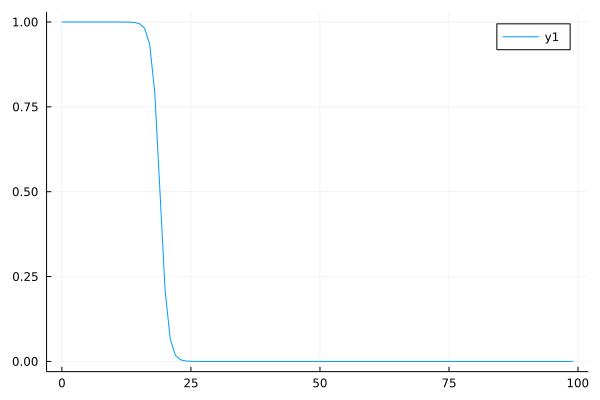

In [14]:
x = 0:Δx:Δx*(ngrid-1) |> collect
plot(x,ϕ[:,1])

In [15]:
position(ϕ,Δx,mgrid)

20.00000000000356

For `DifferentialEquations.jl` to do its work, we need to give it the problem in the formulation:

$$ u_t = f(u) $$

Let's define that right hand side $f(u)$ based on our phase field formulation:

In [16]:
function f(dϕ, ϕ, p, t)
    neumann!(ϕ)
    step!(dϕ,ϕ,p)
end

f (generic function with 1 method)

We formulate the semi-discretized system as an `ODEProblem` which is an abstraction that `DifferentialEquations.jl` provides. We pass our RHS, the initial condition $\varphi_0$, the time span of interest and the model parameters.

In [17]:
tspan = (0,100)
prob = ODEProblem(f, ϕ, tspan, p)

ODEProblem with uType Matrix{Float64} and tType Int64. In-place: true
timespan: (0, 100)
u0: 100×3 Matrix{Float64}:
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 0.999998  0.999998  0.999998
 ⋮                   
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0

To solve the system in time, we employ a Chebyshev method, more specifically the stabilized fourth order Runge-Kutta method, which is implemented in the function `ROCK4()`.

In [18]:
sol = solve(prob, ROCK4(), saveat = 10.0, progress = true)

retcode: Success
Interpolation: 1st order linear
t: 11-element Vector{Float64}:
   0.0
  10.0
  20.0
  30.0
  40.0
  50.0
  60.0
  70.0
  80.0
  90.0
 100.0
u: 11-element Vector{Matrix{Float64}}:
 [0.9999999999900488 0.9999999999900488 0.9999999999900488; 0.9999999999622486 0.9999999999622486 0.9999999999622486; … ; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [1.0000000126318338 1.0000000126318338 1.0000000126318338; 1.0000000126318338 1.0000000090960264 1.0000000126318338; … ; -3.658746611897994e-44 -2.2352194288757304e-43 -3.658746611897994e-44; -3.658746611897994e-44 -3.658746611897994e-44 -3.658746611897994e-44]
 [1.000000189196696 1.000000189196696 1.000000189196696; 1.000000189196696 1.000000236781722 1.000000189196696; … ; 1.3971889765860217e-31 3.1280824947542146e-31 1.3971889765860217e-31; 1.3971889765860217e-31 1.3971889765860217e-31 1.3971889765860217e-31]
 [1.000000512535725 1.000000512535725 1.000000512535725; 1.000000512535725 1.0000005393772422 1.000000512535725; … ; -8.427225524579678e-

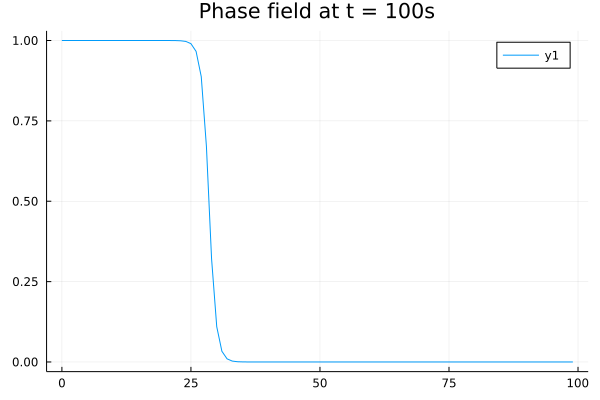

In [19]:
plot(x,sol[end][:,1], title = "Phase field at t = $(tspan[end])s")

`eachindex` is a function that conveniently outputs a range that automatically includes all elements of an array. This is especially useful when operating on multidimensional arrays, as this function then automatically visits each index in a memory-friendly fashion (i.e. along the strides).

In [20]:
positions = zeros(length(sol))
@inbounds for i ∈ eachindex(sol)
    positions[i] = position(sol[i],Δx,mgrid)
end

In [21]:
t = range(tspan[1], tspan[end], length = 500) |> collect
position_theory = positions[1] .+ M / Γ * μ₀ .* t;

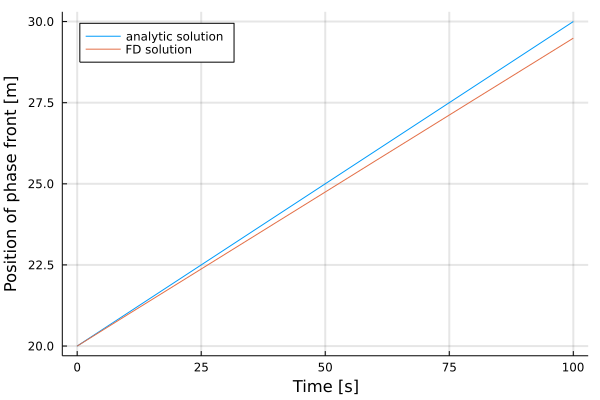

In [22]:
plot(t, position_theory, label = "analytic solution", xlabel = "Time [s]", ylabel = "Position of phase front [m]", legend = :topleft)
plot!(sol.t, positions, label = "FD solution", grids = :all, gridlinewidth = 2.0)

Just for fun, let's see how resource usage is for solving our semi-discretized problem. Just like above, we simply need to use one additional macro:

In [23]:
@benchmark sol = solve($prob, ROCK4(), saveat = 10.0)

BenchmarkTools.Trial: 1791 samples with 1 evaluation.
 Range (min … max):  1.927 ms … 15.211 ms  ┊ GC (min … max):  0.00% … 81.74%
 Time  (median):     2.314 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   2.763 ms ±  1.771 ms  ┊ GC (mean ± σ):  10.36% ± 13.01%

  █▇▆▆▆▄▄▃▂                                                  ▁
  ███████████▅▆▅▆▄▄▄▁▄▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▄▆▄▆▇▆▆▅▅ █
  1.93 ms      Histogram: log(frequency) by time     12.4 ms <

 Memory estimate: 3.26 MiB, allocs estimate: 6318.

As expected, this doesn't take long at all - not bad. However, we need to keep in mind that Julia is a just-in-time compiled language. That means that the first execution of the program takes considerably longer because compile time is included. What we see here are the timings of subsequent executions. So especially for simulations, take that number with a grain of salt.

# Vanishing grain problem

Next, we investigate an unstable circular grain that is located in the center of a rectangular domain. In order so save some time, we only look at a quarter slice of the original domain.

In [55]:
mgrid = 52
ngrid = 50
# Grid spacing [m]
Δx = 1.0

# Radius of the nucleus
r = 20.0
# Location of the nucleus center
r₀ = (0.0, 0.0)


(0.0, 0.0)

In [25]:
tspan = (0.,100.)

(0.0, 100.0)

In [26]:
# Model parameters
Γ   = 50.0                 # [J/m^2] interface energy
ξ   = 4.0                  # [m] phasefield interface width
M   = 1.0                  # [m^2/s] kinetic coefficient
μ₀  = 0.0                  # [J/m^3] bulk energy density difference (driving force)

# Params vector
p = vcat(Γ,ξ,M,μ₀,Δx);

The initial condition reads:

$$
u(r,t=0) = \frac{1}{2}\left(1 - \mathrm{tanh}\frac{r-R_0}{\xi}\right)
$$

Where $R_0$ is the radius of the nucleus and $\xi = 2a$ is the interface width.

In [27]:
function circular_nucleus(x,y,center,ξ,r)
    dist_to_center = sqrt((x - center[1])^2+(y - center[2])^2)
    return 0.5*(1.0 - tanh((dist_to_center - r)/ξ))
end
#= Mutating function that imposes the initial condition on a field φ
Args:
    φ: AbstractMatrix{Float}
    ξ: Number
    r: Number
    r₀: Tuple
Returns:
    φ
=#
function initial!(ϕ, ξ, r, r₀, Δx)
    @inbounds for i ∈ 1:size(ϕ,1)
        @inbounds for j ∈ 1:size(ϕ,2)
            @views ϕ[i,j] = circular_nucleus(i*Δx,j*Δx,r₀,ξ,r)
        end
    end
end

initial! (generic function with 1 method)

In [28]:
ϕ₀ = zeros(ngrid,mgrid)
initial!(ϕ₀,ξ,r,r₀,Δx)

In [29]:
xs = range(0,Δx*mgrid, length=mgrid) |> collect
ys = range(0,Δx*ngrid, length=ngrid) |> collect
x_grid = [x for x = xs for y = ys]
y_grid = [y for x = xs for y = ys];

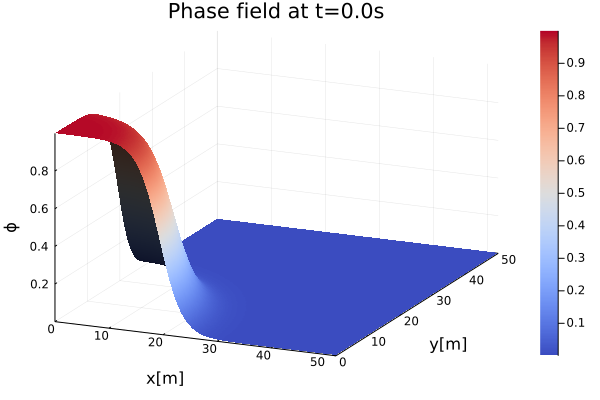

In [30]:
plot(x_grid, y_grid, reshape(ϕ₀,:), st = :surface, camera = (30,50), c = :coolwarm, title = "Phase field at t=$(tspan[1])s", zlabel = "ϕ", xlabel = "x[m]", ylabel = "y[m]")

Again, we assemble the ODE problem using our ODE function `f`, the IC $\phi_0$, the time span and the model parameters.

In [31]:
prob = ODEProblem(f, ϕ₀, tspan, p);

For convenience and sake of comparability, we use identical settings for the solver, i.e. we employ the RK4 algorithm once again:

In [32]:
sol = solve(prob, ROCK4(), saveat = 10.0, progress = true)

retcode: Success
Interpolation: 1st order linear
t: 11-element Vector{Float64}:
   0.0
  10.0
  20.0
  30.0
  40.0
  50.0
  60.0
  70.0
  80.0
  90.0
 100.0
u: 11-element Vector{Matrix{Float64}}:
 [0.9999079321995433 0.9998611484071415 … 1.846319090947901e-7 1.1199547594875625e-7; 0.9998611484071415 0.9998132935875019 … 1.8193788625664453e-7 1.1039248537514368e-7; … ; 5.01781028061643e-7 4.941631235322319e-7 … 9.665990230445232e-12 6.728673174194455e-12; 3.043766858001895e-7 2.998473556670156e-7 … 6.823541731648675e-12 4.766631533925647e-12]
 [0.9992295078208091 0.9992295078208091 … 2.86998321249569e-7 2.86998321249569e-7; 0.9992295078208091 0.9992668992959753 … 2.586403616727561e-7 2.86998321249569e-7; … ; 7.741241136901697e-7 6.970865492889706e-7 … 2.397869461489248e-11 2.6140639131676995e-11; 7.741241136901697e-7 7.741241136901697e-7 … 2.6140639131676995e-11 2.6140639131676995e-11]
 [0.9988968196401755 0.9988968196401755 … 2.5659221882742614e-7 2.5659221882742614e-7; 0.9988968196401

Notice how the solution time only marginally differs from our (pseudo) 1D problem, although the grid is much larger!

Let's visualize the last time step of the solution, which we can access just like an array, although the underlying struct holds a lot more information.

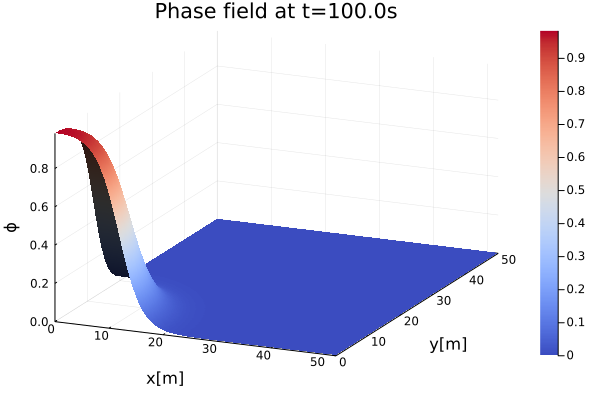

In [33]:
plot(x_grid, y_grid, reshape(sol[end],:), st = :surface, camera = (30,50), c = :coolwarm, title = "Phase field at t=$(tspan[end])s", zlabel = "ϕ", xlabel = "x[m]", ylabel = "y[m]")

Now, let's compare that against an analytical solution. The temporal evolution of the radius is given by:

$$
R(t)=\sqrt{R_{0}^{2}-2K\Gamma t}
$$

In [34]:
radius_model = zeros(length(sol))
for i ∈ eachindex(sol)
    radius_model[i] = sqrt(4.0 * integral(sol[i],Δx) / π)
end
radius_model
radius_theory = sqrt.(max.(0.0,(radius_model[1]^2 .- 2.0 * M .* t)));

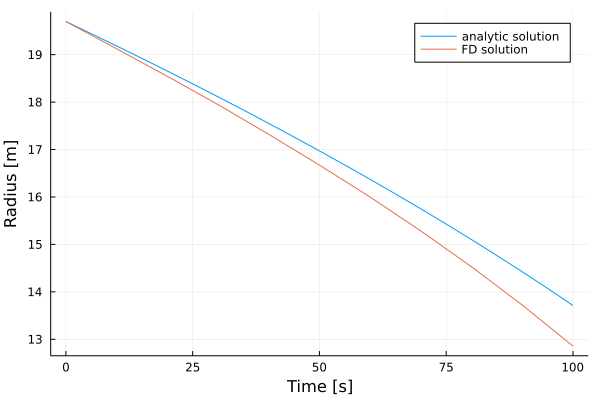

In [35]:
plot(t, radius_theory, label = "analytic solution", xlabel = "Time [s]", ylabel = "Radius [m]", legend = :topright)
plot!(sol.t, radius_model, label = "FD solution")

In [36]:
@benchmark sol = solve($prob, ROCK4(), saveat = 10.0)

BenchmarkTools.Trial: 447 samples with 1 evaluation.
 Range (min … max):   9.398 ms … 28.106 ms  ┊ GC (min … max): 0.00% … 36.63%
 Time  (median):     10.740 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.138 ms ±  1.676 ms  ┊ GC (mean ± σ):  1.94% ±  6.40%

         ▃▃█▇▂▂▁                                               
  ▄▆▇▆▇▇████████▆▆▅▄▄▃▃▃▄▃▃▃▃▂▃▂▁▁▁▂▂▁▁▂▁▂▂▁▁▃▂▃▃▁▃▂▁▁▂▃▃▂▂▁▃ ▃
  9.4 ms          Histogram: frequency by time        17.2 ms <

 Memory estimate: 3.91 MiB, allocs estimate: 4663.

Notice how execution time did not go up linearly with the problem size: For the 1D Problem we had 100 x 3 = 300 grid points, whereas for the 2D simulation we had 52x50 = 2.600 points. Following this calculation, we would expect an increase in execution time larger than the approximate 5x we have seen. It is also notable that the number of allocations stayed approximately constant.

# Some more optimizations

We can employ some additional measures to make our code more performant and especially more suitable for running it on architectures other than the CPU.

One key component is re-writing the loops using stencils in matrix form. As we are dealing with a discretized system, the usually infinite-dimensional laplacian operator can be expressed as a finite-dimensional operator in matrix form.

The (element-wise) laplacian in central difference form reads:

$$ \Delta u \approx \begin{bmatrix} 1 & -2 & 1 \end{bmatrix} \cdot \begin{bmatrix} u_{-1} \\ u_0 \\ u_1 \end{bmatrix} $$

Now, if we want to go to town and do this along a vector of $u$ values, the derivative needs to become a matrix. In this case we obtain a tridiagonal matrix with $[1,-2,1]$ is the central band.

$$ D = \frac{1}{\Delta x^2} \begin{bmatrix}
-2 & 1 &  &  &  &  \\
1 & -2 & 1 &  &  &  \\
 & 1 & -2 & 1 &  &  \\
 &  & 1 & \ddots &  &  \\
 &  &  &  & \ddots & 1 \\
 &  &  &  & 1 & -2 
\end{bmatrix} $$

If we multiply this on our 2D field $\phi$ with $D \cdot \Phi$ with $\Phi$ being the field matrix, we perform diffusion along the y-direction of the field since that is the dimension we preserve in this matrix multiplication.

That leaves the x-direction to operate on. Similarly, we can take care of this by multiplying $\Phi$ with the same stencil from the right side, so that the laplacian in 2D becomes:

$$ \Delta \Phi \approx D_y \Phi + \Phi D_x $$

Lets Code that. It is useful to the compiler to know about arrays that won't change in size, because by default they are mutable in size (in contrast to tuples). We can annotate them using `const` to restrict this and give the compiler more freedom for optimization. Our laplacian arrays fulfill that criterion.

In [37]:
using LinearAlgebra
const Mx = 1/Δx^2 * Tridiagonal([1.0 for i ∈ 1:mgrid-1], [-2.0 for i ∈ 1:mgrid], [1.0 for i ∈ 1:mgrid-1])
const My = 1/Δx^2 * Tridiagonal([1.0 for i ∈ 1:ngrid-1], [-2.0 for i ∈ 1:ngrid], [1.0 for i ∈ 1:ngrid-1])

50×50 Tridiagonal{Float64, Vector{Float64}}:
 -2.0   1.0    ⋅     ⋅     ⋅     ⋅   …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  1.0  -2.0   1.0    ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅    1.0  -2.0   1.0    ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅    1.0  -2.0   1.0    ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅    1.0  -2.0   1.0       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅    1.0  -2.0  …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅    1.0       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋮                             ⋮    ⋱         ⋮                      
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅    

We can even incorporate the Neumann BC in a smart way into this stencil.

We wish to eliminate the flux of the field at the boundaries, i.e. for a 1D stencil at the left and right side of the domain. First, we imagine another "virtual" element left of the leftmost element $u_0$. So the laplacian at the leftmost element $u_1$ becomes:

$$ \Delta u_1 \approx \frac{u_0 - 2 u_1 + u_2}{\Delta x^2} $$

Now, if we want the flux to vanish, we should set $u_0$ equal to $u_2$, as the second derivative then becomes zero. By doing this we get:

$$ \Delta u_1 \approx \frac{- 2 u_1 + 2 u_2}{\Delta x^2} $$

The treatment of the other boundary is analogous as well as manipulating the stencil for the other direction. However for `My` we need to do this in a flipped way as the concatenation in the matrix product there is row-wise and not column-wise.

In [38]:
Mx[2,1] = 1/Δx^2 * 2.0
Mx[end-1,end] = 1/Δx^2 * 2.0
My[1,2] = 1/Δx^2 * 2.0
My[end,end-1] = 1/Δx^2 * 2.0;

Now, why is this so important?

One of the most powerful features in Julia is called multiple dispatch. That means you can have multiple definitions of one function that do different things depending of the types of their arguments. For example, that's how the simple addition operator `+` is impelemented efficiently in Julia. There's just hundreds of definitions for about any combination of data types imaginable, `Int + Int`, `Float64 + Float64`, `BigInt + BigInt` and so on.

How does this help us here? It turns out that the hardware-specialized libraries such as `CUDA.jl` implement their functions simply by overloading the usual functions with definitions for the hardware-specific types (such as `CuArray`).

Multiple dispatch is one reason. The other is that visiting each element in an array like we did in the implementation above is just so ineffective to do on GPUs that it bogs down the entire program. That's why in `CUDA.jl` an error will be thrown when this so-called scalar indexing is detected. However, general matrix multiplication (or GEMM) is blazing fast - and it doesn't hurt performance on the CPU, so it just makes sense to rewrite it this way.

For the source terms, there's not much left to do actually, since we can easily broadcast the scalar functions element-wise over the entire array using the broadcast function / the dot-operator - which in Julia really is just syntactic sugar. That means, calling `dg.(ϕ)` is just another way of calling `broadcast(dg, ϕ)`. So we leave `dg` and `dh` as they are.

Broadcasting is also a thing that GPUs like in Julia since the vectorized operations are abstracted away in the libraries, so if we can express our function this way, we actually need not worry.

We can now re-write the right hand side of the ODE given our new stencil:

In [39]:
function f(dϕ, ϕ, p, t)
    dϕ = p[3] * ( (My * ϕ + ϕ * Mx)  - 2.0/p[2]^2 * dg.(ϕ) + p[4]/(3.0*p[1]*p[2]) * dh.(ϕ) )
end

f (generic function with 1 method)

Note that by incorporating the Neumann BC into the stencil directly, we have gotten rid of the Neumann update step entirely.

So what else can we do? In general, it's a good idea to avoid allocations as discussed earlier. To see what's going on under the hood, we can use another macro that Julia itself provides: `@code_lowered`

In [40]:
@code_lowered My * ϕ

CodeInfo(
1 ─ %1 = LinearAlgebra.eltype(A)
│   %2 = LinearAlgebra.eltype(B)
│        TS = LinearAlgebra.promote_op(LinearAlgebra.matprod, %1, %2)
│   %4 = TS
│   %5 = LinearAlgebra.size(A, 1)
│   %6 = LinearAlgebra.size(B, 2)
│   %7 = Core.tuple(%5, %6)
│   %8 = LinearAlgebra.similar(B, %4, %7)
│   %9 = LinearAlgebra.mul!(%8, A, B)
└──      return %9
)

What this macro does is that it outputs the function sequence that our input is converted to. Or in other words we can see what an overloaded function does in the background. In this case we called `*` on two Array types and want to see what's going on.

From the output we see two things:
1. Julia calls the mutating function `mul!` on the inputs. That is a function implemented in the `LinearAlgebra` package which interfaces to OpenBLAS by default.
2. As a first argument to `mul!`, a temporarily allocated array is passed that has the dimensions of the output and is generated by the `similar` function.

Now in this case, it might be worthwile to pre-allocate this array since we have to do this multiplication a lot of times and it would be inefficient to create and destroy the array all the time.

In [41]:
const My_ϕ = zeros(ngrid, mgrid)
const ϕ_Mx = zeros(ngrid,mgrid)

50×52 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱  ⋮                        ⋮    
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     

Let's look at the output now when we call `mul!` directly:

In [42]:
@code_lowered mul!(My_ϕ,My,ϕ)

CodeInfo(
1 ─      nothing
│   %2 = LinearAlgebra.mul!(C, A, B, true, false)
└──      return %2
)

We can see that the allocation along with all the necessary type inference is gone, so we managed to do exactly what we wanted - not bothering the compiler with stuff we already know in practice.

So what did that get us performance-wise?

In [57]:
ϕ = randn(ngrid,mgrid);

In [58]:
@benchmark $My * $ϕ + $ϕ * $Mx

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  157.800 μs …   8.699 ms  ┊ GC (min … max): 0.00% … 95.19%
 Time  (median):     187.650 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   224.801 μs ± 271.491 μs  ┊ GC (mean ± σ):  4.70% ±  3.92%

  ▂▄▆█▇▆▅▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁                               ▂
  █████████████████████████████████████▇█▇▇▆▇▇▇▆▇▆▇▇▆▇▆▆▆▆▄▅▄▅▆ █
  158 μs        Histogram: log(frequency) by time        489 μs <

 Memory estimate: 190.73 KiB, allocs estimate: 31.

In [59]:
@benchmark mul!($My_ϕ,$My,$ϕ) + mul!($ϕ_Mx,$ϕ,$Mx)

BenchmarkTools.Trial: 10000 samples with 4 evaluations.
 Range (min … max):   5.550 μs …  1.925 ms  ┊ GC (min … max): 0.00% … 98.92%
 Time  (median):      8.575 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.000 μs ± 39.042 μs  ┊ GC (mean ± σ):  9.01% ±  2.61%

  ▅█▇▅▄▅▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁                                      ▂
  ██████████████████████████▇▇▇▇▇▆▅▅▅▅▆▆▆▅▆▅▃▄▄▆▅▂▂▂▄▂▂▅▄▄▄▄▄ █
  5.55 μs      Histogram: log(frequency) by time      40.9 μs <

 Memory estimate: 20.39 KiB, allocs estimate: 2.

We came down from an average execution time of 185.6 µs to 8.4 µs and almost eliminated all allocations (the remainder is likely due to the addition). Not bad at all.

Now let's update our right hand side once again. This time, we will call `mul!` with our new pre-allocated arrays by ourselves and leave the rest as it was.
When modeling the equation itself, we use the broadcast macro `@.` which again is basically just syntactic sugar. It automatically broadcasts all function calls within the expression that follows the macro. In this case those are simply `dg` and `dh`.

In [45]:
function f(dϕ,ϕ,p,t)
    mul!(My_ϕ,My,ϕ)
    mul!(ϕ_Mx,ϕ,Mx)
    @. dϕ = p[3] * ( My_ϕ + ϕ_Mx - 2.0/p[2]^2 * dg(ϕ) + p[4]/(3.0*p[1]*p[2]) * dh(ϕ) )
end

f (generic function with 1 method)

In [46]:
prob = ODEProblem(f, ϕ₀, tspan, p);

In [47]:
sol = solve(prob, ROCK4(), saveat = 10.0, progress = true)

retcode: Success
Interpolation: 1st order linear
t: 11-element Vector{Float64}:
   0.0
  10.0
  20.0
  30.0
  40.0
  50.0
  60.0
  70.0
  80.0
  90.0
 100.0
u: 11-element Vector{Matrix{Float64}}:
 [0.9999079321995433 0.9998611484071415 … 1.846319090947901e-7 1.1199547594875625e-7; 0.9998611484071415 0.9998132935875019 … 1.8193788625664453e-7 1.1039248537514368e-7; … ; 5.01781028061643e-7 4.941631235322319e-7 … 9.665990230445232e-12 6.728673174194455e-12; 3.043766858001895e-7 2.998473556670156e-7 … 6.823541731648675e-12 4.766631533925647e-12]
 [0.999490950938127 0.9994526531987095 … 2.2687449493591078e-7 2.0115236756238467e-7; 0.9994526531987095 0.9994128741524942 … 2.2559775524149681e-7 2.0003004230191708e-7; … ; 6.123104525453131e-7 6.087294476512128e-7 … 1.8493979218538318e-11 1.7305828943311877e-11; 5.429770489581198e-7 5.398296531588211e-7 … 1.7385739320903374e-11 1.6274625003817807e-11]
 [0.9992587344794372 0.9992078512957824 … 2.0291655883336906e-7 1.8072774017553502e-7; 0.999207

In [48]:
@benchmark sol = solve($prob, ROCK4(), saveat = 10.0)

BenchmarkTools.Trial: 461 samples with 1 evaluation.
 Range (min … max):   8.037 ms … 25.071 ms  ┊ GC (min … max): 0.00% … 57.99%
 Time  (median):      9.731 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.769 ms ±  2.720 ms  ┊ GC (mean ± σ):  1.73% ±  6.68%

   ▂▅█▆▆▅▃▂▁ ▂                                                 
  ▅█████████▇█▆▄▄▆▃▅▆▆▃▃▃▄▄▃▄▃▃▄▄▃▃▃▃▄▃▂▂▃▃▁▃▄▃▃▂▃▂▂▁▃▁▁▁▃▁▁▂ ▃
  8.04 ms         Histogram: frequency by time        19.7 ms <

 Memory estimate: 2.57 MiB, allocs estimate: 3045.

As we can see, compared to our previous implementation, we didn't gain an awful lot - but keep in mind that this is a single-threaded application. As soon as we get to many workers doing the computations in parallel, this effort will pay off.

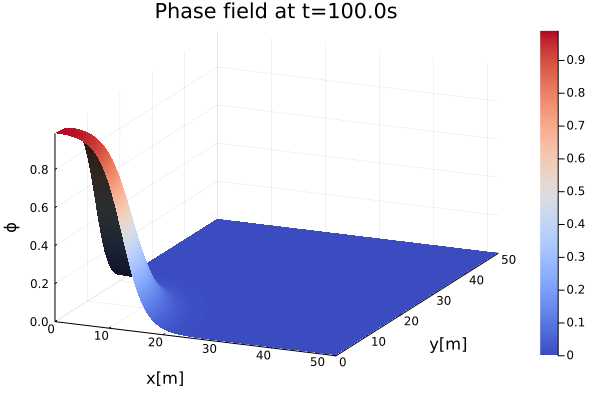

In [49]:
plot(x_grid, y_grid, reshape(sol[end],:), st = :surface, camera = (30,50), c = :coolwarm, title = "Phase field at t=$(tspan[end])s", zlabel = "ϕ", xlabel = "x[m]", ylabel = "y[m]")

In [50]:
radius_model = zeros(length(sol))
for i ∈ eachindex(sol)
    radius_model[i] = sqrt(4.0 * integral(sol[i],Δx) / π)
end
radius_model
radius_theory = sqrt.(max.(0.0,(radius_model[1]^2 .- 2.0 * M .* t)));

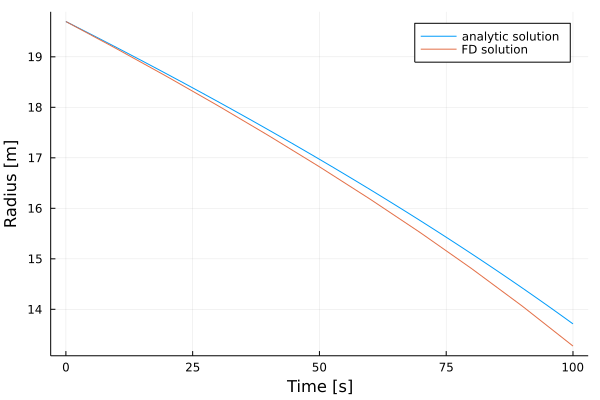

In [51]:
plot(t, radius_theory, label = "analytic solution", xlabel = "Time [s]", ylabel = "Radius [m]", legend = :topright)
plot!(sol.t, radius_model, label = "FD solution")